In [108]:
# Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Blitz Prediction: Milestone 2 Background

*Thomas Garity, Christopher Doyle, Chris Ruano, Hans Elasri, Rishi Hazra*

In **Milestone 2,** we conducted exploratory data analysis (EDA). This included:
- Loading all data tables and inspecting the variables
  - As you will read below, our data is stored in separate tables for games, players, plays, player_plays (what each player does on each play), and then finally the X/Y coordinates of the player on each play.
- Preprocessing
  - We have infilled nAns where needed and one-hot encoded player positions and team names -- we thought about dropping these variables but they may prove useful later for modelling.
- Creating an indicator response variable: `isPlayBlitz`
  - This is waht we seek to predict, using mainly data from the plays and player_play datasets. The response variable was used using data from the player_play dataset, and then we filtered based on the conditions of that play (whether the ball was passed or rushed, etc.)
- Creating a df to use for preliminary modelling: `blitz_df`

We also report on some weaknesses / things yet to explore further, at the bottom of our notebook.


### Data Structure

Our data can be downloaded from the 2025 Big Data Bowl on  <a href="https://www.kaggle.com/competitions/nfl-big-data-bowl-2025/data">Kaggle</a>

or using the Kaggle API: 

`kaggle competitions download -c nfl-big-data-bowl-2025`


**Instructions:**
- Download the dataset and unzip the file `nfl-big-data-bowl-2025.zip`
- The datasets will now saved in a `\nfl-big-data-bowl-2205` directory within the project repo
- Ensure that this directory is listed out in your `.gitignore` file to avoid pushing/pulling this to github

Now, check that the data have been downloaded:

In [109]:
# Ensure that all tables have been downloaded
print("Data Availabe: ")
os.listdir('./nfl-big-data-bowl-2025/')

Data Availabe: 


['plays.csv',
 'tracking_week_4.csv',
 'tracking_week_3.csv',
 'tracking_week_2.csv',
 'tracking_week_1.csv',
 'players.csv',
 'games.csv',
 'tracking_week_8.csv',
 'player_play.csv']

In [110]:
# Print the total size of the dataset
!du -sh nfl-big-data-bowl-2025


3.6G	nfl-big-data-bowl-2025


We see that we have 3.6GB of data downloaded. Let's now load and inspect our data:

In [111]:
# Load CSVs of data -- we only load one week of tracking to inspect its contents

plays_df = pd.read_csv('./nfl-big-data-bowl-2025/plays.csv')
players_df = pd.read_csv('./nfl-big-data-bowl-2025/players.csv')
games_df = pd.read_csv('./nfl-big-data-bowl-2025/games.csv')
player_play_df = pd.read_csv('./nfl-big-data-bowl-2025/player_play.csv')
tracking_week1 = pd.read_csv('./nfl-big-data-bowl-2025/tracking_week_1.csv')

In [112]:
# Look at first few rows
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [113]:
players_df.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [114]:
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [115]:
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
tracking_week1.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022091200,64,35459.0,Kareem Jackson,1,BEFORE_SNAP,2022-09-13 00:16:03.5,22.0,DEN,right,51.06,28.55,0.72,0.37,0.07,246.17,68.34,huddle_break_offense
1,2022091200,64,35459.0,Kareem Jackson,2,BEFORE_SNAP,2022-09-13 00:16:03.6,22.0,DEN,right,51.13,28.57,0.71,0.36,0.07,245.41,71.21,NaN
2,2022091200,64,35459.0,Kareem Jackson,3,BEFORE_SNAP,2022-09-13 00:16:03.7,22.0,DEN,right,51.20,28.59,0.69,0.23,0.07,244.45,69.90,NaN
3,2022091200,64,35459.0,Kareem Jackson,4,BEFORE_SNAP,2022-09-13 00:16:03.8,22.0,DEN,right,51.26,28.62,0.67,0.22,0.07,244.45,67.98,NaN
4,2022091200,64,35459.0,Kareem Jackson,5,BEFORE_SNAP,2022-09-13 00:16:03.9,22.0,DEN,right,51.32,28.65,0.65,0.34,0.07,245.74,62.83,NaN


### Defining the Blitz Indicator (`isPlayBlitz`)

In order to estimate the likelihood of a blitz based on pre-snap information, we must first clearly define what constitutes a blitz.  

Since the dataset does not include an explicit "blitz" label, we construct a proxy indicator variable, `isPlayBlitz`, using post-play player-level statistics. This label flags a defender as blitzing if they show any of the following characteristics:

- Identified as an **initial pass rusher**  
- **Caused pressure** on the quarterback  
- **Recorded a QB hit**  
- **Credited with a sack**

These conditions collectively approximate the presence of a blitz, particularly when applied to non-defensive-line players (e.g., linebackers or defensive backs). The resulting indicator variable will serve as the target label for our blitz prediction model.


In [117]:
player_play_df

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354722,2022110700,3787,52666,NO,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354723,2022110700,3787,52942,NO,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354724,2022110700,3787,53098,NO,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354725,2022110700,3787,54476,NO,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Copy player_play_df
blitz_df = player_play_df.copy()

# Merge position info into blitz_df
blitz_df = blitz_df.merge(players_df[['nflId', 'position']], on='nflId', how='left')

# Define set of non-DL positions
non_dl_positions = ['CB', 'FS', 'SS', 'NB', 'LB', 'ILB', 'OLB', 'MLB', 'DB']

# Define isPlayerBlitz flag
blitz_df['isPlayerBlitz'] = (
    (blitz_df['position'].isin(non_dl_positions)) &
    (
        (blitz_df['wasInitialPassRusher'] == 1) |
        (blitz_df['causedPressure'] == True) |
        (blitz_df['quarterbackHit'] == True) |
        (blitz_df['sackYardsAsDefense'].fillna(0) > 0)
    )
).astype(int)


# Merge play info into blitz_df
blitz_df = blitz_df.merge(plays_df, on=['gameId', 'playId'], how='left', suffixes=('_left', '_right'))

# Merge game info into blitz_df
blitz_df = blitz_df.merge(games_df, on='gameId', how='left', suffixes=('_left', '_right'))


# Drop unnecessary columns
cols_to_drop = [col for col in blitz_df.columns if col.endswith('_right')]
blitz_df.drop(columns=cols_to_drop, inplace=True)
cols_to_rename = {col: col[:-2].strip() for col in blitz_df.columns if col.endswith('_left')}
blitz_df.rename(columns=cols_to_rename, inplace=True)


In [119]:
# Aggregate to play level
play_blitz = blitz_df.groupby(['gameId', 'playId'])['isPlayerBlitz'].max().reset_index()
play_blitz.rename(columns={'isPlayerBlitz': 'isPlayBlitz'}, inplace=True)

# Merge back into player-level data
blitz_df = blitz_df.merge(play_blitz, on=['gameId', 'playId'], how='left')

In [120]:
print(len(blitz_df))
print(len(blitz_df.drop_duplicates(['gameId', 'playId', 'nflId'])))


354727
354727


In [121]:
# Pick one sample (gameId, playId) where isPlayBlitz is 0
sample = blitz_df[blitz_df['isPlayBlitz'] == 0][['gameId', 'playId']].iloc[0]
sample_game_id = sample['gameId']
sample_play_id = sample['playId']

print("Sampling play: ", sample_game_id, sample_play_id)

# Now filter correctly using both
subset = blitz_df[(blitz_df['gameId'] == sample_game_id) & (blitz_df['playId'] == sample_play_id)]
print(f"Unique values for isPlayBlitz in play {sample_play_id}:", subset['isPlayBlitz'].value_counts())


Sampling play:  2022090800 56
Unique values for isPlayBlitz in play 56: isPlayBlitz
0    22
Name: count, dtype: int64


In [122]:
blitz_df['qbSpike'].unique()

array([False, nan, True], dtype=object)

So, clearly we have some preprocessing work to do later -- some Nans snuck in

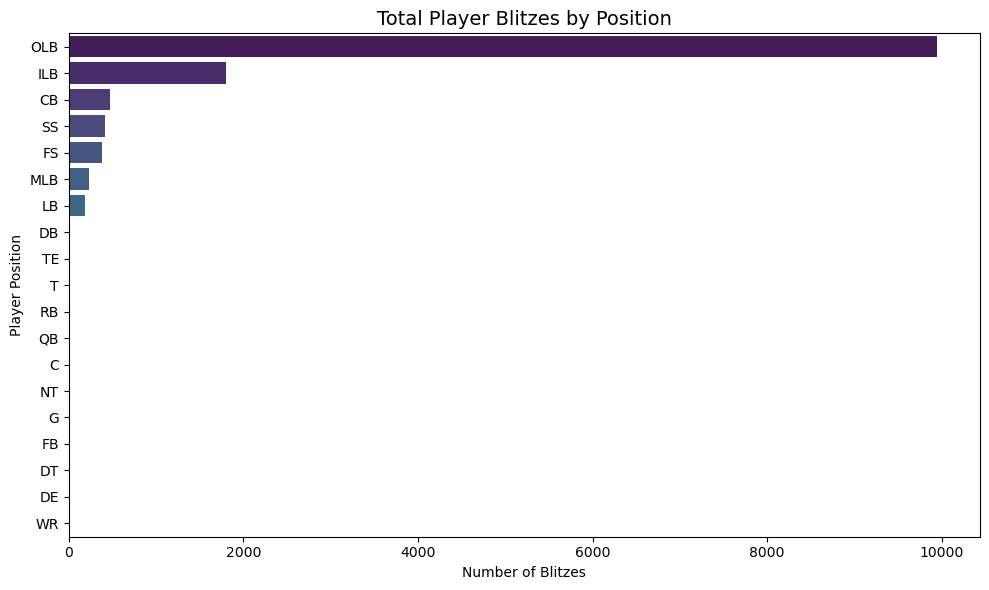

In [123]:
# Group by position to see who blitzes most
blitz_by_position = (
    blitz_df.groupby('position')['isPlayerBlitz']
    .sum()
    .reset_index()
    .sort_values(by='isPlayerBlitz', ascending=False)
)

# Plot blitz count by position
plt.figure(figsize=(10, 6))
sns.barplot(data=blitz_by_position, x='isPlayerBlitz', y='position', palette='viridis', hue='position', legend=False)

plt.title('Total Player Blitzes by Position', fontsize=14)
plt.xlabel('Number of Blitzes')
plt.ylabel('Player Position')
plt.tight_layout()
plt.show()

Here we see that it is **defensive** positions who blitz most, suggesting that we have correctly flagged blitzes.

### Preprocessing

Next, we preprocess our `blitz_df` to only include passing plays (blitzes on passing plays are far rarer, and teams generally need help determining when a defense will blitz on a passing play). 

#### 1. Filtering, Filling Missing Values

In [124]:
print(blitz_df.columns.tolist())

['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt', 'rushingYards', 'hadDropback', 'passingYards', 'sackYardsAsOffense', 'hadPassReception', 'receivingYards', 'wasTargettedReceiver', 'yardageGainedAfterTheCatch', 'fumbles', 'fumbleLost', 'fumbleOutOfBounds', 'assistedTackle', 'forcedFumbleAsDefense', 'halfSackYardsAsDefense', 'passDefensed', 'quarterbackHit', 'sackYardsAsDefense', 'safetyAsDefense', 'soloTackle', 'tackleAssist', 'tackleForALoss', 'tackleForALossYardage', 'hadInterception', 'interceptionYards', 'fumbleRecoveries', 'fumbleRecoveryYards', 'penaltyYards_le', 'penaltyNames', 'wasInitialPassRusher', 'causedPressure', 'timeToPressureAsPassRusher', 'getOffTimeAsPassRusher', 'inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset', 'wasRunningRoute', 'routeRan', 'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3', 'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker', 'pff_defensiveCoverageAssignment', 'pff_primaryDefensiveCoverageMatchupNf

In [125]:
playId = 56
print(f"Number of rows in playId = {playId}: {len(blitz_df[blitz_df['playId'] == playId])}")
print("Unique Values for qbSpike: ", blitz_df[blitz_df['playId'] == playId]['qbSpike'].unique())

Number of rows in playId = 56: 1012
Unique Values for qbSpike:  [False nan]


We see that there are some NANs present in the columns that we wish to use to filter ; we impute these by assuming that if `qbSpike` is true for some players on the play, then it is true for the ENTIRE play. We apply this logic to all columns that will be used to filter.



In [126]:
for col_name in ['isDropback', 'qbSpike', 'qbKneel', 'playAction']:
  blitz_df[col_name] = blitz_df.groupby('playId')[col_name].transform(lambda x: x.ffill().bfill())

  # Check for remaining NaNs after fill
  # Count the number of rows with at least one NaN value
  nan_count = blitz_df[col_name].isna().sum()
  print(f'Number of rows in {col_name} with NaNs: {nan_count}')

Number of rows in isDropback with NaNs: 0


/var/folders/0q/yhmj_0x575vb_7r2qv4fkhs40000gn/T/ipykernel_32008/1154778608.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blitz_df[col_name] = blitz_df.groupby('playId')[col_name].transform(lambda x: x.ffill().bfill())


Number of rows in qbSpike with NaNs: 16214
Number of rows in qbKneel with NaNs: 0
Number of rows in playAction with NaNs: 0


We can see that there are still some missing values -- luckily, this will be addressed by our filtering below:

In [127]:
# Check that there is no overlap in playId between the included and excluded plays
# First, get disqualified playIds (any row matching exclusion criteria)
included_play_ids = blitz_df[
    (blitz_df['isDropback'] == True) &
    (blitz_df['qbSpike'] != True) &
    pd.notna(blitz_df['qbSpike']) &
    (blitz_df['qbKneel'] != True) &
    (blitz_df['playAction'] != True)
]['playId'].unique()

# Then include only playIds NOT in excluded list
excluded_play_df = blitz_df[~blitz_df['playId'].isin(included_play_ids)]

# Confirm unique playId counts
print("Total unique plays: ", blitz_df['playId'].nunique())
print("Plays included: ", len(included_play_ids))
print("Plays excluded: ", excluded_play_df['playId'].nunique())

# Check how we've reduced rows in dataset
print("Rows in original dataset: ", len(blitz_df))
filtered_blitz_df = blitz_df[blitz_df['playId'].isin(included_play_ids)]
print("Rows in filtered dataset: ", len(filtered_blitz_df))

Total unique plays:  4207
Plays included:  3473
Plays excluded:  734
Rows in original dataset:  354727
Rows in filtered dataset:  316777


So we see that we have retained most of the data, leaving us with healthy number of rows.

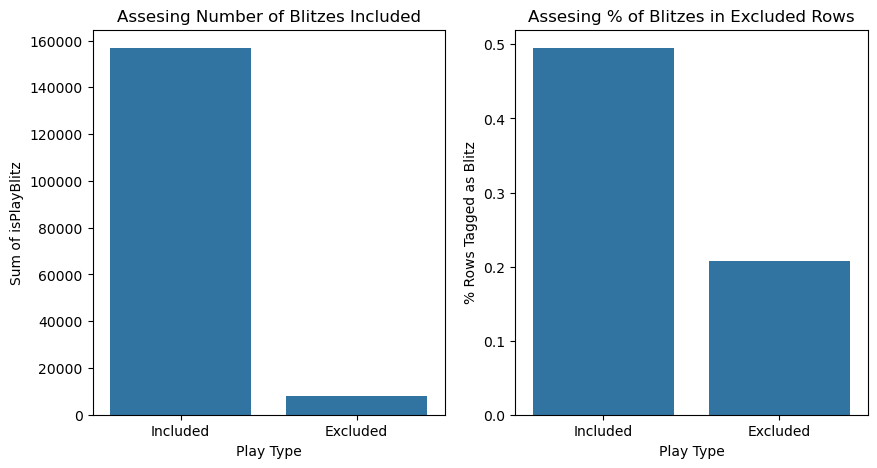

In [128]:
data = {"Play Type": ['Included',
                      'Excluded'],
        "Sum of isPlayBlitz": [filtered_blitz_df['isPlayBlitz'].sum(),
                           excluded_play_df['isPlayBlitz'].sum()],
        "% Rows Tagged as Blitz": [filtered_blitz_df['isPlayBlitz'].sum() / len(filtered_blitz_df),
                                   excluded_play_df['isPlayBlitz'].sum()/ len(excluded_play_df)]}
data = pd.DataFrame(data)


fig, axs = plt.subplots(1, 2, figsize=(10,5))

sns.barplot(data=data, x="Play Type", y="Sum of isPlayBlitz", ax=axs[0])
axs[0].set_title("Assesing Number of Blitzes Included")

sns.barplot(data=data, x="Play Type", y="% Rows Tagged as Blitz", ax=axs[1])
axs[1].set_title("Assesing % of Blitzes in Excluded Rows")

plt.tight_layout
plt.show()

In [129]:
# Finally, set our df to the filtered one
blitz_df = filtered_blitz_df

Here, we can deduce that our filtering has given us the desired effects:
1. We keep most of the blitzes
2. There is a markedly lower rate of blitzes (12% vs 6%) in the included vs excluded datasets.

#### 2. One Hot Encoding

Let's first check for categorical variables:

In [130]:
def print_non_numeric(df):
  # Select non-numeric columns
  non_numeric_df = df.select_dtypes(exclude=['number', 'bool'])

  # Get column names of non-numeric columns
  non_numeric_columns = non_numeric_df.columns.tolist()

  print(non_numeric_columns)

print_non_numeric(blitz_df)

['teamAbbr', 'penaltyNames', 'inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset', 'routeRan', 'pff_defensiveCoverageAssignment', 'position', 'playDescription', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'gameClock', 'playNullifiedByPenalty', 'offenseFormation', 'receiverAlignment', 'passResult', 'dropbackType', 'passLocationType', 'passTippedAtLine', 'unblockedPressure', 'qbSpike', 'qbSneak', 'rushLocationType', 'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_passCoverage', 'pff_manZone', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr']


In [131]:
# Let's start by one-hot encoding the position variable
blitz_df_encoded = pd.get_dummies(blitz_df, columns=['position','routeRan', 'teamAbbr', 'penaltyNames', 'pff_defensiveCoverageAssignment', ])

# Now print our non-numeric variables
print_non_numeric(blitz_df_encoded)

['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset', 'playDescription', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'gameClock', 'playNullifiedByPenalty', 'offenseFormation', 'receiverAlignment', 'passResult', 'dropbackType', 'passLocationType', 'passTippedAtLine', 'unblockedPressure', 'qbSpike', 'qbSneak', 'rushLocationType', 'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_passCoverage', 'pff_manZone', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr']


All that is left now is to infill NaNs in the 3 columns `['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset']`. We do this by assuming that each player keeps the same values of these 3 variables for the entire play.

THIS CELL TAKES A LONG TIME TO RUN. -- it is commented out for now, since these were not values we inspected in EDA.

In [132]:
'''
for col_name in ['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset']:
  blitz_df_encoded[col_name] = blitz_df_encoded.groupby(['playId','nflId'])[col_name].transform(lambda x: x.ffill())


blitz_df = blitz_df_encoded
'''

"\nfor col_name in ['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset']:\n  blitz_df_encoded[col_name] = blitz_df_encoded.groupby(['playId','nflId'])[col_name].transform(lambda x: x.ffill())\n\n\nblitz_df = blitz_df_encoded\n"

Thus we have fixed our missing values and one-hot encoded any categorical variables. We are ready to begin modelling! Some steps that may still need to be addressed are:

- Incorporating positional data -- the X and Y position of players on the field. If we wish to use those, we should begin work with the `tracking_week_x.csv` data, where x is a gameweek. This opens the door to more advanced architectures (that take in an "image" of the field and guess the next positions)
- Packaging the data into model-specific formats. Each modelling approach will require a different format of data. For example, we could try creating a "cube" where each position is saved as a "pixel" in an image of the field, and the num_channels is the number of collumns we have (excluding the position).
- Better infilling methods -- we may find that in some cases, the indicator variables above may change during a play. -- **This was adjusted using isPlayBlitz and isPLayerBlitz** in MS3

# EDA - Milestone 3

## Blitz Summary Statistics

Now that we have our data cleaning and preprocessing done, we can poke into the dataset to get a better understanding of what we are working with. Of course, our primary goal is to study when teams/players blitz, so we start there.

### Class Imbalance

First we investigate if there is a class imbalance in the dataset with how many blitz plays vs non-blitz plays there are:

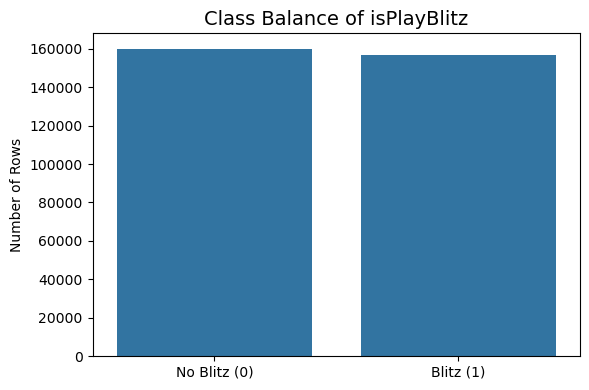

Blitz rate: 0.49503594010928825


In [133]:
blitz_counts = blitz_df['isPlayBlitz'].value_counts().sort_index()
blitz_labels = ['No Blitz (0)', 'Blitz (1)']

plt.figure(figsize=(6,4))
sns.barplot(x=blitz_labels, y=blitz_counts.values)
plt.title("Class Balance of isPlayBlitz", fontsize=14)
plt.ylabel("Number of Rows")
plt.tight_layout()
plt.show()

print("Blitz rate:", blitz_counts[1] / blitz_counts.sum())

Clearly, we have a class imbalance, but since we are doing a binary classification the imbalance is not too concerning. It may be necessary to do upsampling in order to force the model to learn how to predict a blitz. Further, we should this blitz rate in mind when evaluating the accuracy of our predictions on a test/validation set.

### Correlation Heatmap

Because isPlayBlitz is an imputed variable, this may not be as indicative of possible relationships.

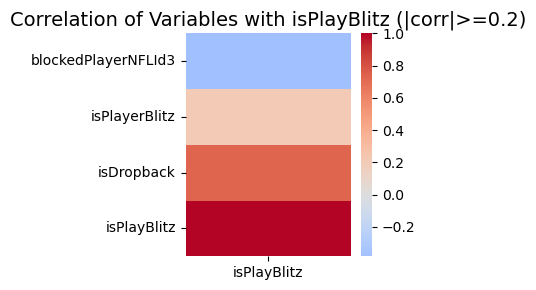

In [134]:
blitz_corr = blitz_df.corr(numeric_only=True)

threshold = 0.2
filtered_corr = blitz_corr[['isPlayBlitz']]
filtered_corr = filtered_corr[filtered_corr['isPlayBlitz'].abs() >= threshold]

plt.figure(figsize=(4, max(3, len(filtered_corr)*0.5)))
sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title("Correlation of Variables with isPlayBlitz (|corr|>=0.2)", fontsize=14)
plt.tight_layout()
plt.show()

### Blitz by down

Teams likely base some of their decision making of when to blitz based on what down it is, we may expect that there is some correlation between the blitz predictor and what down it is. Lets investigate:

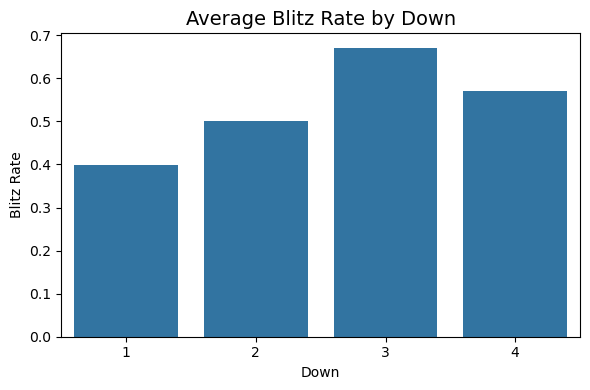

In [135]:
down_blitz = blitz_df.groupby('down')['isPlayBlitz'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=down_blitz, x='down', y='isPlayBlitz')
plt.title("Average Blitz Rate by Down", fontsize=14)
plt.xlabel("Down")
plt.ylabel("Blitz Rate")
plt.tight_layout()
plt.show()

### Blitz by score differential

Teams may also decide to blitz based on allowed risk margins (i.e. in a very lopsided game, blitzing may be a highly risky move, sacrificing some defensive coverage).

This cell takes 2-3 minutes to run.

In [136]:
def compute_score_diff(row):
    game_info = games_df.loc[games_df['gameId'] == row['gameId']]
    if row['possessionTeam'] == game_info['homeTeamAbbr'].values[0]:
        return game_info['homeFinalScore'].values[0] - game_info['visitorFinalScore'].values[0]
    else:
        return game_info['visitorFinalScore'].values[0] - game_info['homeFinalScore'].values[0]
blitz_df['scoreDiff'] = blitz_df.apply(compute_score_diff, axis=1)

/var/folders/0q/yhmj_0x575vb_7r2qv4fkhs40000gn/T/ipykernel_32008/1632924846.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blitz_rate_by_score = blitz_df.groupby('score_bin')['isPlayBlitz'].mean().reset_index()


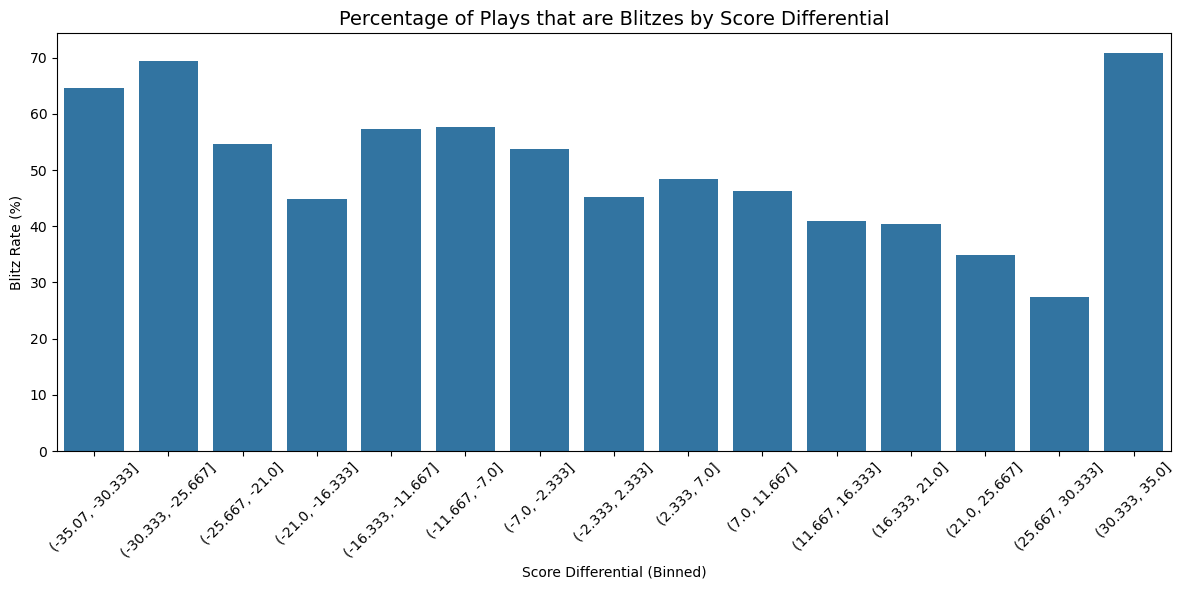

In [137]:
blitz_df['score_bin'] = pd.cut(blitz_df['scoreDiff'], bins=15)
blitz_rate_by_score = blitz_df.groupby('score_bin')['isPlayBlitz'].mean().reset_index()
blitz_rate_by_score['blitz_percent'] = blitz_rate_by_score['isPlayBlitz'] * 100

# nplot blitz rate by score difference
plt.figure(figsize=(12, 6))
sns.barplot(data=blitz_rate_by_score, x='score_bin', y='blitz_percent')
plt.title("Percentage of Plays that are Blitzes by Score Differential", fontsize=14)
plt.xlabel("Score Differential (Binned)")
plt.ylabel("Blitz Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There appears to be minimal relationship between the score differential and percentage of plays that are a Blitz.

### Blitz by Yards to Go

/var/folders/0q/yhmj_0x575vb_7r2qv4fkhs40000gn/T/ipykernel_32008/2796273136.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blitz_rate_by_bucket = blitz_df.groupby('yardsToGo_bucket')['isPlayBlitz'].mean().reset_index()


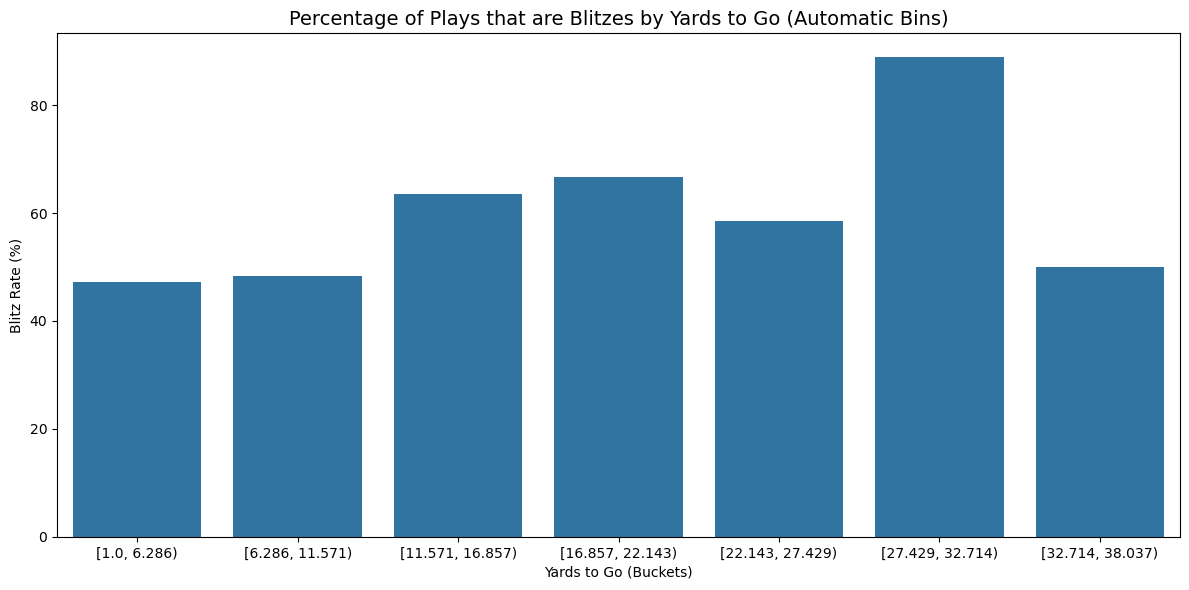

In [138]:
num_bins = 7

blitz_df['yardsToGo_bucket'] = pd.cut(blitz_df['yardsToGo'], bins=num_bins, right=False)

blitz_rate_by_bucket = blitz_df.groupby('yardsToGo_bucket')['isPlayBlitz'].mean().reset_index()
blitz_rate_by_bucket['blitz_percent'] = blitz_rate_by_bucket['isPlayBlitz'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=blitz_rate_by_bucket, x='yardsToGo_bucket', y='blitz_percent')
plt.title("Percentage of Plays that are Blitzes by Yards to Go (Automatic Bins)", fontsize=14)
plt.xlabel("Yards to Go (Buckets)")
plt.ylabel("Blitz Rate (%)")
plt.tight_layout()
plt.show()

It is not immediately clear whether there is a relationship between yards to go and incidence of blitzes. But there does seem to be a dip in blitz instances at either very high or relatively low yards to go.

### Blitz by Team

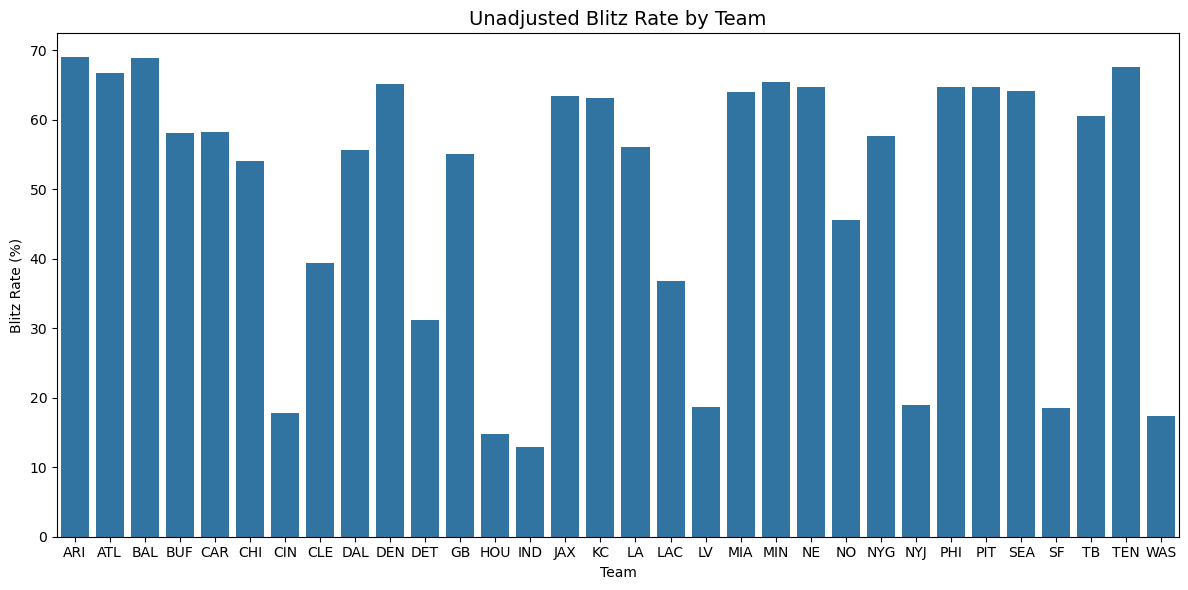

In [139]:
import statsmodels.formula.api as smf
import numpy as np

blitz_df['teamAbbr'] = np.where(
    blitz_df['homeTeamAbbr'] == blitz_df['possessionTeam'],
    blitz_df['visitorTeamAbbr'],
    blitz_df['homeTeamAbbr']
)

blitz_rate_by_team = blitz_df.groupby('teamAbbr')['isPlayBlitz'].mean().reset_index()
blitz_rate_by_team['blitz_percent'] = blitz_rate_by_team['isPlayBlitz'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=blitz_rate_by_team, x='teamAbbr', y='blitz_percent')
plt.title("Unadjusted Blitz Rate by Team", fontsize=14)
plt.xlabel("Team")
plt.ylabel("Blitz Rate (%)")
plt.tight_layout()
plt.show()

                           Logit Regression Results                           
Dep. Variable:            isPlayBlitz   No. Observations:               316777
Model:                          Logit   Df Residuals:                   316742
Method:                           MLE   Df Model:                           34
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:                  0.1719
Time:                        20:56:02   Log-Likelihood:            -1.8181e+05
converged:                       True   LL-Null:                   -2.1956e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.3504      0.027    -49.283      0.000      -1.404      -1.297
C(teamAbbr)[T.ATL]    -0.1692      0.030     -5.639      0.000      -0.228      -0.110
C(teamAbbr)[T.BAL]  

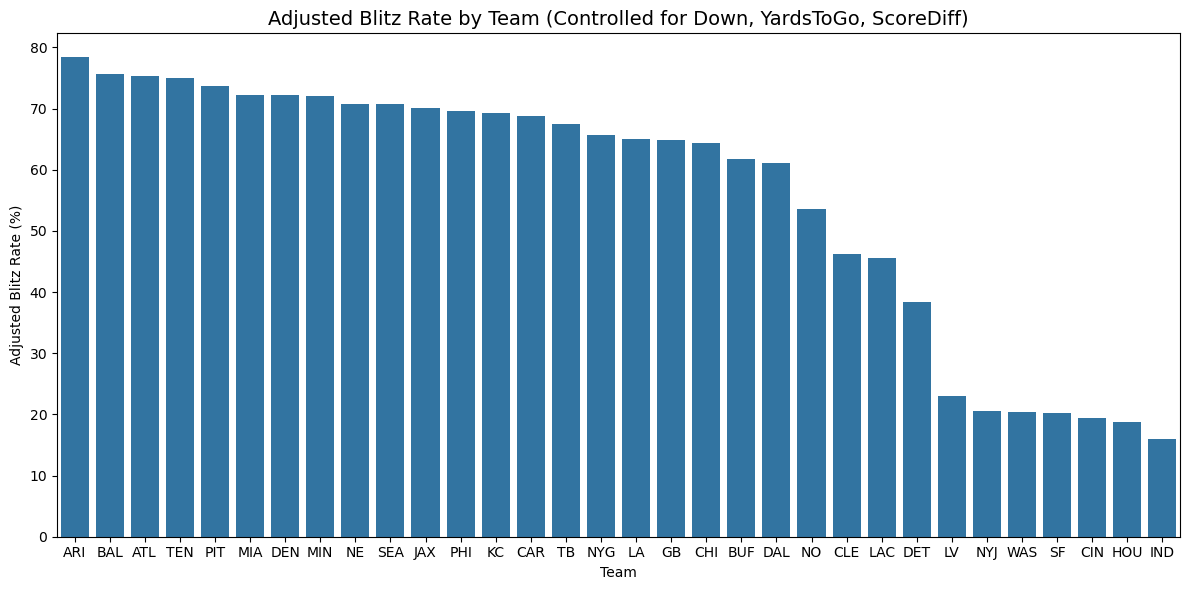

In [140]:
model = smf.logit("isPlayBlitz ~ C(teamAbbr) + down + yardsToGo + scoreDiff", data=blitz_df).fit(disp=False)
print(model.summary())

typical_down = blitz_df['down'].median()
typical_yards = blitz_df['yardsToGo'].median()
typical_score = blitz_df['scoreDiff'].median()

teams = blitz_df['teamAbbr'].unique()
pred_df = pd.DataFrame({
    'teamAbbr': teams,
    'down': typical_down,
    'yardsToGo': typical_yards,
    'scoreDiff': typical_score
})

# Predict probability for each team.
pred_df['predicted_prob'] = model.predict(pred_df)
pred_df['predicted_percent'] = pred_df['predicted_prob'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=pred_df.sort_values('predicted_percent', ascending=False), x='teamAbbr', y='predicted_percent')
plt.title("Adjusted Blitz Rate by Team (Controlled for Down, YardsToGo, ScoreDiff)", fontsize=14)
plt.xlabel("Team")
plt.ylabel("Adjusted Blitz Rate (%)")
plt.tight_layout()
plt.show()

There does not appear to be much differentiation across different teams in relation to blitz rates.

### Blitz By Offensive Formation

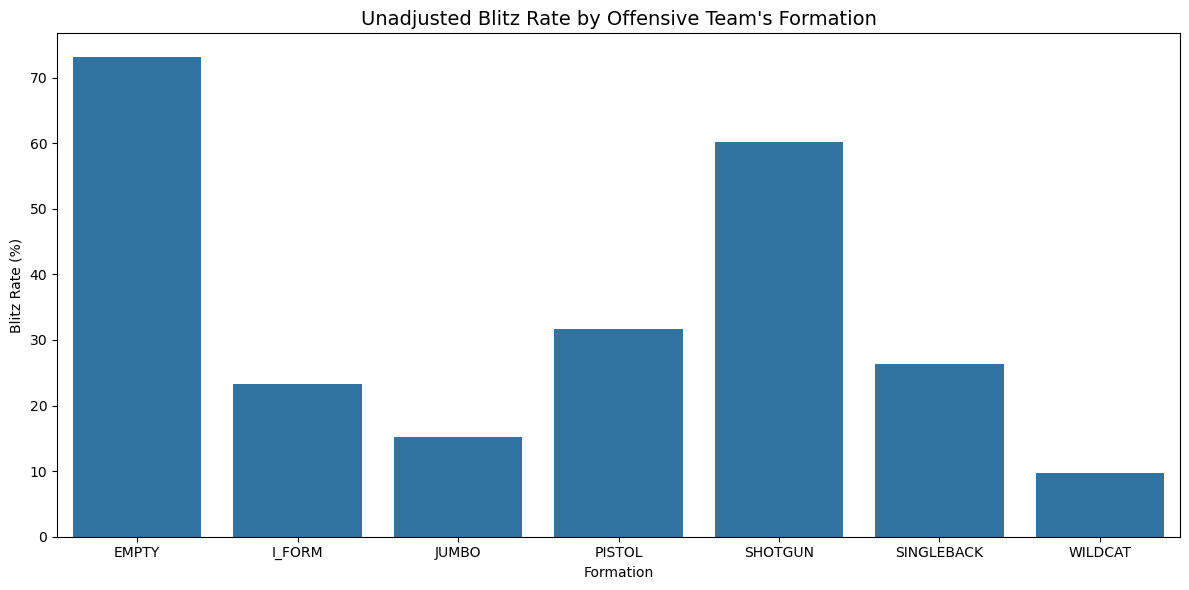

In [141]:
# Blitz by offensive formation
import statsmodels.formula.api as smf
import numpy as np


blitz_rate_by_off_formation = blitz_df.groupby('offenseFormation')['isPlayBlitz'].mean().reset_index()
blitz_rate_by_off_formation['blitz_percent'] = blitz_rate_by_off_formation['isPlayBlitz'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=blitz_rate_by_off_formation, x='offenseFormation', y='blitz_percent')
plt.title("Unadjusted Blitz Rate by Offensive Team's Formation", fontsize=14)
plt.xlabel("Formation")
plt.ylabel("Blitz Rate (%)")
plt.tight_layout()
plt.show()

### Blitz By Time to Pressure, Time to Sack

In these plots, we see a new trend: there is a relatively structured distribution (normal) of the two predictors for plays with blitzes. For plays without blitzes, the data appears to be drawn from a more uniform distribution or a normal distribution with a large variance.

One could conclude that blitzes occur under defined circumstances -- whereas a multitude of factors could lead to a non-blitz.

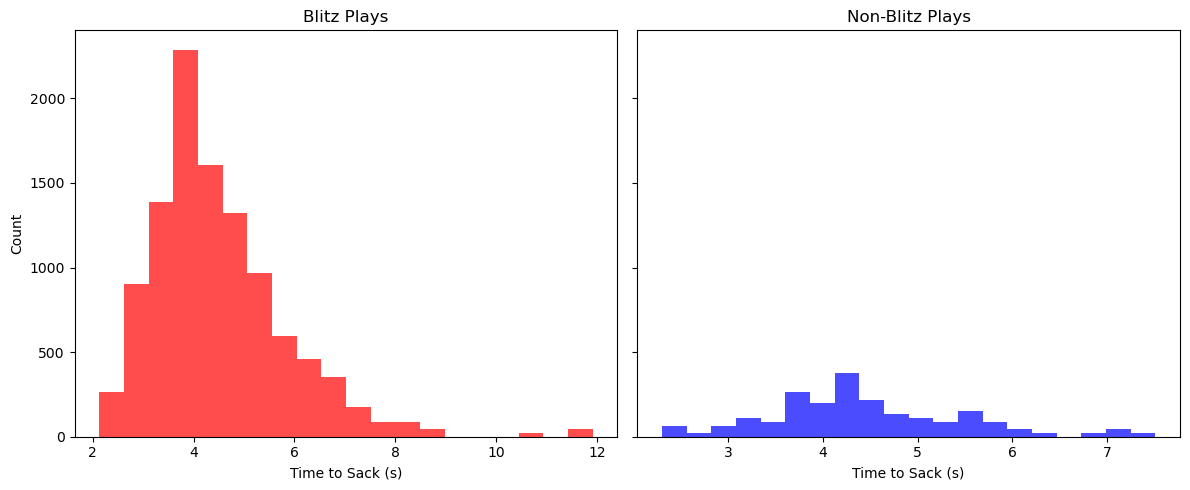

In [144]:
import matplotlib.pyplot as plt

# Split dataset based on isPlayBlitz
blitz_df_isPlayblitz = blitz_df[blitz_df['isPlayBlitz'] == 1]
blitz_df_not_isPlayblitz = blitz_df[blitz_df['isPlayBlitz'] == 0]

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Histogram for blitz plays
axs[0].hist(blitz_df_isPlayblitz['timeToSack'].dropna(), bins=20, color='red', alpha=0.7)
axs[0].set_title('Blitz Plays')
axs[0].set_xlabel('Time to Sack (s)')
axs[0].set_ylabel('Count')

# Histogram for non-blitz plays
axs[1].hist(blitz_df_not_isPlayblitz['timeToSack'].dropna(), bins=20, color='blue', alpha=0.7)
axs[1].set_title('Non-Blitz Plays')
axs[1].set_xlabel('Time to Sack (s)')

# Layout
plt.tight_layout()
plt.show()


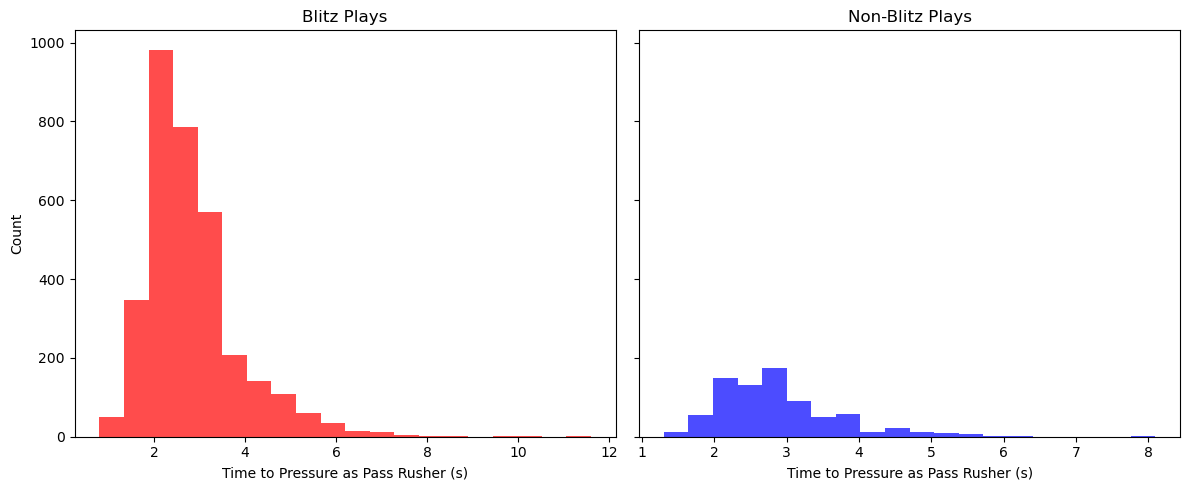

In [143]:
import matplotlib.pyplot as plt

# Split dataset based on isPlayBlitz
blitz_df_isPlayblitz = blitz_df[blitz_df['isPlayBlitz'] == 1]
blitz_df_not_isPlayblitz = blitz_df[blitz_df['isPlayBlitz'] == 0]

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Histogram for blitz plays
axs[0].hist(blitz_df_isPlayblitz['timeToPressureAsPassRusher'].dropna(), bins=20, color='red', alpha=0.7)
axs[0].set_title('Blitz Plays')
axs[0].set_xlabel('Time to Pressure as Pass Rusher (s)')
axs[0].set_ylabel('Count')

# Histogram for non-blitz plays
axs[1].hist(blitz_df_not_isPlayblitz['timeToPressureAsPassRusher'].dropna(), bins=20, color='blue', alpha=0.7)
axs[1].set_title('Non-Blitz Plays')
axs[1].set_xlabel('Time to Pressure as Pass Rusher (s)')

# Layout
plt.tight_layout()
plt.show()
